## Trial-level early stopping in Ax

This tutorial illustrates how to add a trial-level early stopping strategy to an Ax hyper-parameter optimization (HPO) loop. The goal of trial-level early stopping is to monitor the results of expensive evaluations and terminate those that are unlikely to produce promising results, freeing up resources to explore more configurations.

Most of this tutorial is adapted from the [PyTorch Ax Multiobjective NAS Tutorial](https://pytorch.org/tutorials/intermediate/ax_multiobjective_nas_tutorial.html). The training job is different from the original in that we do not optimize `batch_size` or `epochs`. This was done for illustrative purposes, as each validation curve now has the same number of points. The companion training file `mnist_train_nas.py` has also been altered to log to Tensorboard during training.

NOTE: Although the original NAS tutorial is for a multi-objective problem, this tutorial focuses on a single objective (validation accuracy) problem. Early stopping currently does not support \"true\" multi-objective stopping, although one can use [logical compositions of early stopping strategies](https://github.com/facebook/Ax/blob/main/ax/early_stopping/strategies/logical.py) to target multiple objectives separately. Early stopping for the multi-objective case is currently a work in progress.

In [1]:
import os
import tempfile

from pathlib import Path

import torchx

from ax.core import Experiment, Objective, ParameterType, RangeParameter, SearchSpace
from ax.core.optimization_config import OptimizationConfig

from ax.early_stopping.strategies import PercentileEarlyStoppingStrategy
from ax.metrics.tensorboard import TensorboardCurveMetric

from ax.modelbridge.dispatch_utils import choose_generation_strategy

from ax.runners.torchx import TorchXRunner

from ax.service.scheduler import Scheduler, SchedulerOptions
from ax.service.utils.report_utils import exp_to_df

from torchx import specs
from torchx.components import utils

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Defining the TorchX App

Our goal is to optimize the PyTorch Lightning training job defined in
[mnist_train_nas.py](https://github.com/pytorch/tutorials/tree/master/intermediate_source/mnist_train_nas.py)_.
To do this using TorchX, we write a helper function that takes in
the values of the architcture and hyperparameters of the training
job and creates a [TorchX AppDef](https://pytorch.org/torchx/latest/basics.html)_
with the appropriate settings.



In [3]:
if SMOKE_TEST:
    epochs = 3
else:
    epochs = 10

In [4]:
def trainer(
    log_path: str,
    hidden_size_1: int,
    hidden_size_2: int,
    learning_rate: float,
    dropout: float,
    trial_idx: int = -1,
) -> specs.AppDef:

    # define the log path so we can pass it to the TorchX AppDef
    if trial_idx >= 0:
        log_path = Path(log_path).joinpath(str(trial_idx)).absolute().as_posix()

    batch_size = 32

    return utils.python(
        # command line args to the training script
        "--log_path",
        log_path,
        "--hidden_size_1",
        str(hidden_size_1),
        "--hidden_size_2",
        str(hidden_size_2),
        "--learning_rate",
        str(learning_rate),
        "--epochs",
        str(epochs),
        "--dropout",
        str(dropout),
        "--batch_size",
        str(batch_size),
        # other config options
        name="trainer",
        script="tutorials/early_stopping/mnist_train_nas.py",
        image=torchx.version.TORCHX_IMAGE,
    )

## Setting up the Runner

Ax’s [Runner](https://ax.dev/api/core.html#ax.core.runner.Runner)
abstraction allows writing interfaces to various backends.
Ax already comes with Runner for TorchX, so we just need to
configure it. For the purpose of this tutorial, we run jobs locally
in a fully asynchronous fashion. In order to launch them on a cluster, you can instead specify a
different TorchX scheduler and adjust the configuration appropriately.
For example, if you have a Kubernetes cluster, you just need to change the
scheduler from ``local_cwd`` to ``kubernetes``.

The training job launched by this runner will log partial results to Tensorboard, which will then be monitored by the early stopping strategy. We will show how this is done using an Ax 
[TensorboardCurveMetric](https://ax.dev/api/metrics.html#module-ax.metrics.tensorboard) below.

In [5]:
# Make a temporary dir to log our results into
log_dir = tempfile.mkdtemp()

ax_runner = TorchXRunner(
    tracker_base="/tmp/",
    component=trainer,
    # NOTE: To launch this job on a cluster instead of locally you can
    # specify a different scheduler and adjust args appropriately.
    scheduler="local_cwd",
    component_const_params={"log_path": log_dir},
    cfg={},
)

## Setting up the SearchSpace

First, we define our search space. Ax supports both range parameters
of type integer and float as well as choice parameters which can have
non-numerical types such as strings.
We will tune the hidden sizes, learning rate, and dropout parameters.

In [6]:
parameters = [
    # NOTE: In a real-world setting, hidden_size_1 and hidden_size_2
    # should probably be powers of 2, but in our simple example this
    # would mean that num_params can't take on that many values, which
    # in turn makes the Pareto frontier look pretty weird.
    RangeParameter(
        name="hidden_size_1",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="hidden_size_2",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="learning_rate",
        lower=1e-4,
        upper=1e-2,
        parameter_type=ParameterType.FLOAT,
        log_scale=True,
    ),
    RangeParameter(
        name="dropout",
        lower=0.0,
        upper=0.5,
        parameter_type=ParameterType.FLOAT,
    ),
]

search_space = SearchSpace(
    parameters=parameters,
    # NOTE: In practice, it may make sense to add a constraint
    # hidden_size_2 <= hidden_size_1
    parameter_constraints=[],
)

## Setting up Metrics

Ax has the concept of a Metric that defines properties of outcomes and how observations are obtained for these outcomes. This allows e.g. encodig how data is fetched from some distributed execution backend and post-processed before being passed as input to Ax.

We will optimize the validation accuracy, which is a `TensorboardCurveMetric` that points to the logging directory assigned above. Note that we have set `is_available_while_running`, allowing for the metric to be queried as the trial progresses. This is critical for the early stopping strategy to monitor partial results.

In [7]:
class MyTensorboardMetric(TensorboardCurveMetric):

    # NOTE: We need to tell the new Tensorboard metric how to get the id /
    # file handle for the tensorboard logs from a trial. In this case
    # our convention is to just save a separate file per trial in
    # the pre-specified log dir.
    @classmethod
    def get_ids_from_trials(cls, trials):
        return {
            trial.index: Path(log_dir).joinpath(str(trial.index)).as_posix()
            for trial in trials
        }

    # This indicates whether the metric is queryable while the trial is
    # still running. This is required for early stopping to monitor the
    # progress of the running trial.ArithmeticError
    @classmethod
    def is_available_while_running(cls):
        return True

In [8]:
val_acc = MyTensorboardMetric(
    name="val_acc",
    curve_name="val_acc",
    lower_is_better=False,
)

## Setting up the OptimizationConfig

The `OptimizationConfig` specifies the objective for Ax to optimize.

In [9]:
opt_config = OptimizationConfig(
    objective=Objective(
        metric=val_acc,
        minimize=False,
    )
)

## Defining an Early Stopping Strategy

A `PercentileEarlyStoppingStrategy` is a simple method that stops a trial if its performance falls below a certain percentile of other trials at the same step (e.g., when `percentile_threshold` is 50, at a given point in time, if a trial ranks in the bottom 50% of trials, it is stopped). 
- We make use of `normalize_progressions` which normalizes the progression column (e.g. timestamp, epochs, training data used) to be in [0, 1]. This is useful because one doesn't need to know the maximum progression values of the curve (which might be, e.g., the total number of data points in the training dataset).
- The `min_progression` parameter specifies that trials should only be considered for stopping if the latest progression value is greater than this threshold.
- The `min_curves` parameter specifies the minimum number of completed curves (i.e., fully completed training jobs) before early stopping will be considered. This should be larger than zero if `normalize_progression` is used. In general, we want a few completed curves to have a baseline for comparison.

Note that `PercentileEarlyStoppingStrategy` does not make use of learning curve modeling or prediction. More sophisticated model-based methods will be available in future versions of Ax.

In [10]:
percentile_early_stopping_strategy = PercentileEarlyStoppingStrategy(
    # stop if in bottom 70% of runs at the same progression
    percentile_threshold=70,
    # the trial must have passed `min_progression` steps before early stopping is initiated
    # note that we are using `normalize_progressions`, so this is on a scale of [0, 1]
    min_progression=0.3,
    # there must be `min_curves` completed trials and `min_curves` trials reporting data in
    # order for early stopping to be applicable
    min_curves=5,
    # specify, e.g., [0, 1] if the first two trials should never be stopped
    trial_indices_to_ignore=None,
    # check for new data every 10 seconds
    seconds_between_polls=10,
    normalize_progressions=True,
)

## Creating the Ax Experiment

In Ax, the Experiment object is the object that stores all the information about the problem setup.

In [11]:
experiment = Experiment(
    name="torchx_mnist",
    search_space=search_space,
    optimization_config=opt_config,
    runner=ax_runner,
)

## Choosing the GenerationStrategy

A [GenerationStrategy](https://ax.dev/api/modelbridge.html#ax.modelbridge.generation_strategy.GenerationStrategy)
is the abstract representation of how we would like to perform the
optimization. While this can be customized (if you’d like to do so, see
[this tutorial](https://ax.dev/tutorials/generation_strategy.html)),
in most cases Ax can automatically determine an appropriate strategy
based on the search space, optimization config, and the total number
of trials we want to run.

Typically, Ax chooses to evaluate a number of random configurations
before starting a model-based Bayesian Optimization strategy.

We remark that in Ax, generation strategies and early stopping strategies are separate, a design decision motivated by ease-of-use. However, we should acknowledge that jointly considering generation and stopping using a single strategy would likely be the "proper" formulation.

In [12]:
if SMOKE_TEST:
    total_trials = 6
else:
    total_trials = 15  # total evaluation budget

gs = choose_generation_strategy(
    search_space=experiment.search_space,
    optimization_config=experiment.optimization_config,
    num_trials=total_trials,
)

[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.


[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=4 num_trials=15 use_batch_trials=False


[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5


[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5


[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: `verbose`, `disable_progbar`, and `jit_compile` are not yet supported when using `choose_generation_strategy` with ModularBoTorchModel, dropping these arguments.


[INFO 05-20 06:42:11] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 5 trials, BoTorch for subsequent trials]). Iterations after 5 will take longer to generate due to model-fitting.


## Configuring the Scheduler

The `Scheduler` acts as the loop control for the optimization.
It communicates with the backend to launch trials, check their status, retrieve (partial) results, and importantly for this tutorial, calls the early stopping strategy. If the early stopping strategy suggests a trial to be the stopped, the `Scheduler` communicates with the backend to terminate the trial.

The ``Scheduler`` requires the ``Experiment`` and the ``GenerationStrategy``.
A set of options can be passed in via ``SchedulerOptions``. Here, we
configure the number of total evaluations as well as ``max_pending_trials``,
the maximum number of trials that should run concurrently. In our
local setting, this is the number of training jobs running as individual
processes, while in a remote execution setting, this would be the number
of machines you want to use in parallel.


In [13]:
scheduler = Scheduler(
    experiment=experiment,
    generation_strategy=gs,
    options=SchedulerOptions(
        total_trials=total_trials,
        max_pending_trials=5,
        early_stopping_strategy=percentile_early_stopping_strategy,
    ),
)

[INFO 05-20 06:42:11] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


In [14]:
%%time
scheduler.run_all_trials()

[INFO 05-20 06:42:11] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:11] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:11] Scheduler: Running trials [0]...


[INFO 05-20 06:42:12] Scheduler: Running trials [1]...


[INFO 05-20 06:42:13] Scheduler: Running trials [2]...


[INFO 05-20 06:42:14] Scheduler: Running trials [3]...


[INFO 05-20 06:42:15] Scheduler: Running trials [4]...


[WARNING 05-20 06:42:16] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 06:42:16] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:16] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/0. Returning without this metric.


[INFO 05-20 06:42:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/1. Returning without this metric.


[INFO 05-20 06:42:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/2. Returning without this metric.


[INFO 05-20 06:42:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:16] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:16] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:16] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:16] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:16] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:16] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:16] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:16] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:16] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:16] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:16] Scheduler: Failed to fetch val_acc for trial 0, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:16] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 0 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:16] Scheduler: Failed to fetch val_acc for trial 1, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:16] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 1 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:16] Scheduler: Failed to fetch val_acc for trial 2, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:16] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 2 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:16] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:16] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:16] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:16] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:16] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:42:26] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:26] Scheduler: Fetching data for trials: 3 - 4 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:26] Scheduler: Retrieved FAILED trials: 0 - 2.


[INFO 05-20 06:42:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:26] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:26] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:26] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:26] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:26] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:26] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:26] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:26] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:26] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:26] Scheduler: Running trials [5]...


[INFO 05-20 06:42:26] Scheduler: Running trials [6]...


[INFO 05-20 06:42:28] Scheduler: Running trials [7]...


[WARNING 05-20 06:42:29] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 06:42:29] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:29] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:42:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:42:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:42:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:29] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:29] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:29] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:29] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:29] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:29] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:42:39] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:39] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:42:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:42:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:42:39] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:39] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:39] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:39] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:39] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:39] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:39] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:39] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:39] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:39] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:39] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:39] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:39] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:39] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:39] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:39] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:39] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:39] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:39] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:39] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:39] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:42:49] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:49] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:42:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:42:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:42:49] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:49] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:49] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:49] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:49] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:49] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:49] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:49] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:49] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:49] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:49] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:49] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:49] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:49] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:49] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:49] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:49] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:49] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:49] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:49] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:49] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:42:59] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:42:59] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:42:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:42:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:42:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:42:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:42:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:42:59] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:59] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:59] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:59] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:42:59] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:42:59] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:59] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:59] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:59] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:42:59] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:42:59] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:59] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:59] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:59] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:59] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:59] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:59] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:59] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:42:59] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:42:59] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:42:59] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:42:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:43:09] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:43:09] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:43:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:43:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:43:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:43:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:43:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:43:09] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:09] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:09] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:09] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:09] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:43:09] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:09] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:09] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:09] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:09] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:43:09] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:09] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:09] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:09] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:09] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:09] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:09] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:09] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:09] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:09] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:43:09] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:43:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:43:19] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:43:19] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:43:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:43:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:43:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:43:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:43:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:43:19] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:19] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:19] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:19] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:19] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:43:19] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:19] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:19] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:19] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:19] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:43:19] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:19] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:19] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:19] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:19] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:19] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:19] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:19] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:19] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:19] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:43:19] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:43:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:43:29] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:43:29] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:43:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/3. Returning without this metric.


[INFO 05-20 06:43:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:43:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:43:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:43:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


[INFO 05-20 06:43:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 06:43:29] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 06:43:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 06:43:29] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 06:43:29] Scheduler: Failed to fetch val_acc for trial 3, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 3 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:29] Scheduler: Failed to fetch val_acc for trial 4, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 4 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:29] Scheduler: Failed to fetch val_acc for trial 5, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 5 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:29] Scheduler: Failed to fetch val_acc for trial 6, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 6 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 06:43:29] Scheduler: Failed to fetch val_acc for trial 7, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 06:43:29] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 7 is still RUNNING continuing the experiment and retrying on next poll...


[INFO 05-20 06:43:29] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 05-20 06:43:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:43:40] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:43:40] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:43:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/4. Returning without this metric.


[INFO 05-20 06:43:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:43:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:43:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:43:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:43:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:43:50] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:43:50] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:43:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:43:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:43:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 06:43:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:43:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:00] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:00] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:44:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:44:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:44:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:44:00] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:10] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:10] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:44:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/5. Returning without this metric.


[INFO 05-20 06:44:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/6. Returning without this metric.


[INFO 05-20 06:44:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:44:10] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:20] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:20] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:44:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 06:44:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:31] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:31] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:44:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/7. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:44:31] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:41] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:41] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:44:41] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:44:51] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:44:51] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:44:52] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:44:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:02] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:02] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:12] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:12] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:12] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:22] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:22] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:33] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:33] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:43] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:43] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:43] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:45:53] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:45:53] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:45:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:45:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:03] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:03] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:14] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:14] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:24] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:24] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:34] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:34] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:34] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:44] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:44] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:45] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:46:55] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:46:55] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:46:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:46:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:05] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:05] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:47:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:15] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:15] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:47:16] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:26] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:26] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:47:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:36] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:36] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:47:36] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:46] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:46] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 06:47:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:47:57] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:47:57] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:47:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:47:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:07] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:07] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:17] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:17] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:27] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:27] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:28] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:38] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:38] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:48] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:48] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:48:58] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:48:58] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:48:59] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:48:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:49:09] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:49:09] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:49:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:49:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:49:19] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:49:19] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:49:19] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:49:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:49:29] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:49:29] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:49:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:49:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:49:39] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:49:39] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:49:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:49:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:49:50] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:49:50] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:49:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:49:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:00] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:00] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:00] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:10] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:10] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:21] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:21] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:31] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:31] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:31] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:41] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:41] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:50:52] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:50:52] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:50:52] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:50:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:02] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:02] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:51:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:12] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:12] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:51:12] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:22] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:22] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:51:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:33] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:51:33] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:43] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:43] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 06:51:43] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:51:53] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:51:53] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:51:54] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:51:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:04] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:04] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:14] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:14] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:24] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:24] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:34] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:34] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:45] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:45] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:45] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:52:55] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:52:55] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:52:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:52:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:05] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:05] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:06] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:16] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:16] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:16] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:26] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:26] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:36] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:36] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:37] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:47] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:47] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:53:57] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:53:57] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:53:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:53:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:07] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:07] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:18] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:18] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:18] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:28] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:28] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:28] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:38] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:38] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:48] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:48] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:49] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:54:59] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:54:59] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:54:59] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:54:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:55:09] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:55:09] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:55:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:55:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:55:19] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:55:19] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:55:20] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:55:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:55:30] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:55:30] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:55:30] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:55:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:55:40] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:55:40] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:55:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:55:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:55:50] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:55:50] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:55:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:55:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:01] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:01] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:11] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:11] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:21] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:21] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:31] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:31] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:42] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:42] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:56:52] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:56:52] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:56:52] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:56:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:02] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:02] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:13] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:13] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:13] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:23] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:23] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:33] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:34] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:44] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:44] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:44] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:57:54] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:57:54] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:57:54] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:57:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:04] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:04] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[WARNING 05-20 06:58:04] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 06:58:04] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:04] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:15] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:15] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:15] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:25] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:25] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:25] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:35] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:35] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:36] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:46] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:46] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:46] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:58:56] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:58:56] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:58:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:58:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:59:06] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:06] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:59:17] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:17] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:59:27] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:27] Scheduler: Fetching data for trials: 3 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 05-20 06:59:37] Scheduler: Fetching data for newly completed trials: [3].


[INFO 05-20 06:59:37] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


[INFO 05-20 06:59:37] Scheduler: Retrieved COMPLETED trials: [3].


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:38] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[WARNING 05-20 06:59:38] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 06:59:38] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:38] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:38] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 06:59:48] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:48] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 06:59:48] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 06:59:58] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 06:59:58] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 06:59:58] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 06:59:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:00:08] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:00:08] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:00:09] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:00:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:00:19] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:00:19] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:00:19] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:00:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:00:29] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:00:29] Scheduler: Fetching data for trials: 4 - 7 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:00:29] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:00:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:00:39] Scheduler: Fetching data for newly completed trials: [4, 6].


[INFO 05-20 07:00:39] Scheduler: Fetching data for trials: [5, 7] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:00:39] Scheduler: Retrieved COMPLETED trials: [4, 6].


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:00:39] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:00:41] Scheduler: Running trials [8]...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:00:43] Scheduler: Running trials [9]...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:00:48] Scheduler: Running trials [10]...


[WARNING 05-20 07:00:49] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:00:49] Scheduler: Fetching data for newly completed trials: [5].


[INFO 05-20 07:00:49] Scheduler: Fetching data for trials: 7 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:00:49] Scheduler: Retrieved COMPLETED trials: [5].


[INFO 05-20 07:00:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:00:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:00:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:00:49] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[WARNING 05-20 07:00:50] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:00:50] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:00:50] Scheduler: Fetching data for trials: 7 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:00:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:00:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:00:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:00:50] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:00:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:01:00] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:00] Scheduler: Fetching data for trials: 7 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:00] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:01:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:01:10] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:10] Scheduler: Fetching data for trials: 7 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:10] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 05-20 07:01:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 05-20 07:01:20] Scheduler: Fetching data for newly completed trials: [7].


[INFO 05-20 07:01:20] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:20] Scheduler: Retrieved COMPLETED trials: [7].


[INFO 05-20 07:01:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 05-20 07:01:21] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[WARNING 05-20 07:01:21] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:01:21] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:21] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


[INFO 05-20 07:01:21] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:21] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:21] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 07:01:21] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:21] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:21] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 07:01:21] Scheduler: Failed to fetch val_acc for trial 8, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:21] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 8 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:21] Scheduler: Failed to fetch val_acc for trial 9, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:21] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 9 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:21] Scheduler: Failed to fetch val_acc for trial 10, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:21] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 10 is still RUNNING continuing the experiment and retrying on next poll...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 05-20 07:01:21] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:01:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:01:31] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:31] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


[INFO 05-20 07:01:31] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:31] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:31] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 07:01:31] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:31] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:31] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 07:01:31] Scheduler: Failed to fetch val_acc for trial 8, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:31] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 8 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:31] Scheduler: Failed to fetch val_acc for trial 9, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:31] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 9 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:31] Scheduler: Failed to fetch val_acc for trial 10, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:31] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 10 is still RUNNING continuing the experiment and retrying on next poll...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 05-20 07:01:31] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:01:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:01:41] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:41] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:01:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/8. Returning without this metric.


[INFO 05-20 07:01:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/9. Returning without this metric.


[INFO 05-20 07:01:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/10. Returning without this metric.


[INFO 05-20 07:01:41] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:41] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[INFO 05-20 07:01:41] ax.core.metric: MetricFetchE INFO: Initialized MetricFetchE(message="DataFrame from curve series is empty")


[ERROR 05-20 07:01:41] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:41] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[ERROR 05-20 07:01:41] ax.core.experiment: Discovered Metric fetching Err while attaching data MetricFetchE(message="DataFrame from curve series is empty"). Ignoring for now -- will retry query on next call to fetch.


[WARNING 05-20 07:01:41] Scheduler: Failed to fetch val_acc for trial 8, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:41] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 8 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:41] Scheduler: Failed to fetch val_acc for trial 9, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:41] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 9 is still RUNNING continuing the experiment and retrying on next poll...


[WARNING 05-20 07:01:41] Scheduler: Failed to fetch val_acc for trial 10, found MetricFetchE(message="DataFrame from curve series is empty").


[INFO 05-20 07:01:41] Scheduler: MetricFetchE INFO: Because val_acc is available_while_running and trial 10 is still RUNNING continuing the experiment and retrying on next poll...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 05-20 07:01:41] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:01:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:01:51] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:01:51] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:01:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.09994666666666667.


[INFO 05-20 07:01:51] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:01:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:01] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:01] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.09994666666666667.


[INFO 05-20 07:02:01] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:11] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:11] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.09994666666666667.


[INFO 05-20 07:02:12] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:22] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:22] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.09994666666666667.


[INFO 05-20 07:02:22] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:32] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:32] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:02:32] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:42] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:42] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:02:42] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:02:52] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:02:52] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:02:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:02:52] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:02:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:02] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:02] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:03:02] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:03:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:12] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:12] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:03:12] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:03:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:22] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:22] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:03:23] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:03:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:33] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:03:33] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:03:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:43] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:43] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:03:43] ax.early_stopping.strategies.percentile: Early stopping decision for 10: True. Reason: Trial objective value 0.9532037377357483 is worse than 70.0-th percentile (0.9569496810436249) across comparable trials.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:03:47] Scheduler: Running trials [11]...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:48] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 05-20 07:03:48] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:03:48] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:48] Scheduler: Fetching data for trials: [8, 9, 11] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:03:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/11. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:03:48] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:03:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:03:58] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:03:58] Scheduler: Fetching data for trials: [8, 9, 11] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:03:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/11. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:03:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
9     0.955039
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.percentile: Early stopping decision for 9: True. Reason: Trial objective value 0.9550392627716064 is worse than 70.0-th percentile (0.9561705350875854) across comparable trials.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:03:58] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11 and metric val_acc. Not early stopping this trial.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:04:02] Scheduler: Running trials [12]...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:03] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 05-20 07:04:03] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:04:03] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:03] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:04:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/11. Returning without this metric.


[INFO 05-20 07:04:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/12. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:04:03] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:04:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:04:13] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:13] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:04:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/11. Returning without this metric.


[INFO 05-20 07:04:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/12. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9607418179512024 is better than 70.0-th percentile (0.9601299881935119) across comparable trials.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:04:13] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:04:23] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:23] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:04:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/11. Returning without this metric.


[INFO 05-20 07:04:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/12. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9607418179512024 is better than 70.0-th percentile (0.9601299881935119) across comparable trials.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:04:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:04:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:33] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:04:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/12. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:04:33] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9607418179512024 is better than 70.0-th percentile (0.9601299881935119) across comparable trials.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:04:33] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:04:43] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:43] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:04:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/12. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:04:44] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9607418179512024 is better than 70.0-th percentile (0.9601299881935119) across comparable trials.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:04:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:04:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:04:54] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:04:54] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 05-20 07:04:54] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:04:54] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.921538
4    0.965406
5    0.938359
6    0.906529
7    0.965476
8    0.965676
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9656761884689331 is better than 70.0-th percentile (0.9654410183429718) across comparable trials.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 05-20 07:04:54] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:04:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:04] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:04] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 05-20 07:05:04] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:05:04] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.921538
4    0.965406
5    0.938359
6    0.906529
7    0.965476
8    0.965676
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9656761884689331 is better than 70.0-th percentile (0.9654410183429718) across comparable trials.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 05-20 07:05:04] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:14] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:14] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 05-20 07:05:14] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.921538
4    0.965406
5    0.938359
6    0.906529
7    0.965476
8    0.965676
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9656761884689331 is better than 70.0-th percentile (0.9654410183429718) across comparable trials.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 05-20 07:05:14] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:24] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:24] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:05:24] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.926731
4    0.965852
5    0.945016
6    0.913170
7    0.972277
8    0.968737
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.968737006187439 is better than 70.0-th percentile (0.9672946631908417) across comparable trials.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 05-20 07:05:24] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:34] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:34] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:05:35] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.926731
4    0.965852
5    0.945016
6    0.913170
7    0.972277
8    0.968737
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.968737006187439 is better than 70.0-th percentile (0.9672946631908417) across comparable trials.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 05-20 07:05:35] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:45] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:45] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.926731
4    0.965852
5    0.945016
6    0.913170
7    0.972277
8    0.968737
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.968737006187439 is better than 70.0-th percentile (0.9672946631908417) across comparable trials.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 05-20 07:05:45] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:05:55] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:05:55] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.926731
4    0.965852
5    0.945016
6    0.913170
7    0.972277
8    0.968737
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.968737006187439 is better than 70.0-th percentile (0.9672946631908417) across comparable trials.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 05-20 07:05:55] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:05:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:05] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:05] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.926731
4    0.965852
5    0.945016
6    0.913170
7    0.972277
8    0.968737
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.968737006187439 is better than 70.0-th percentile (0.9672946631908417) across comparable trials.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 05-20 07:06:05] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:15] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:15] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.928588
4    0.966028
5    0.948681
6    0.914065
7    0.967500
8    0.968058
Name: 0.6999466666666667, dtype: float64.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9680575132369995 is better than 70.0-th percentile (0.966763973236084) across comparable trials.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 05-20 07:06:15] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:25] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:25] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.928588
4    0.966028
5    0.948681
6    0.914065
7    0.967500
8    0.968058
Name: 0.6999466666666667, dtype: float64.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9680575132369995 is better than 70.0-th percentile (0.966763973236084) across comparable trials.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.29994666666666664.


[INFO 05-20 07:06:26] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:36] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:36] Scheduler: Fetching data for trials: [8, 11, 12] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.928588
4    0.966028
5    0.948681
6    0.914065
7    0.967500
8    0.968058
Name: 0.6999466666666667, dtype: float64.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9680575132369995 is better than 70.0-th percentile (0.966763973236084) across comparable trials.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Early stopping decision for 11: True. Reason: Trial objective value 0.9574872255325317 is worse than 70.0-th percentile (0.9594122648239136) across comparable trials.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.29994666666666664.


[INFO 05-20 07:06:36] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:06:38] Scheduler: Running trials [13]...


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:39] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 05-20 07:06:39] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:06:39] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:39] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:06:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/13. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:39] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.928588
4    0.966028
5    0.948681
6    0.914065
7    0.967500
8    0.968058
Name: 0.6999466666666667, dtype: float64.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9680575132369995 is better than 70.0-th percentile (0.966763973236084) across comparable trials.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.29994666666666664.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:06:39] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:06:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:49] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:49] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:06:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/13. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.931095
4    0.968127
5    0.951363
6    0.919642
7    0.972935
8    0.970217
Name: 0.7999466666666667, dtype: float64.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9702171683311462 is better than 70.0-th percentile (0.9691720008850098) across comparable trials.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.29994666666666664.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:06:49] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:06:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:06:59] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:06:59] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:06:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/13. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:06:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.931095
4    0.968127
5    0.951363
6    0.919642
7    0.972935
8    0.970217
Name: 0.7999466666666667, dtype: float64.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9702171683311462 is better than 70.0-th percentile (0.9691720008850098) across comparable trials.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.29994666666666664.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.29994666666666664) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:06:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:06:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:07:09] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:07:09] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:07:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/13. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:07:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.931095
4    0.968127
5    0.951363
6    0.919642
7    0.972935
8    0.970217
Name: 0.7999466666666667, dtype: float64.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9702171683311462 is better than 70.0-th percentile (0.9691720008850098) across comparable trials.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9659069180488586 is better than 70.0-th percentile (0.9607094824314117) across comparable trials.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:07:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:07:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:07:20] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:07:20] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 05-20 07:07:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/13. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:07:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.931095
4    0.968127
5    0.951363
6    0.919642
7    0.972935
8    0.970217
Name: 0.7999466666666667, dtype: float64.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9702171683311462 is better than 70.0-th percentile (0.9691720008850098) across comparable trials.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9659069180488586 is better than 70.0-th percentile (0.9607094824314117) across comparable trials.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:07:20] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:07:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:07:30] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:07:30] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:07:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 05-20 07:07:30] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.931095
4    0.968127
5    0.951363
6    0.919642
7    0.972935
8    0.970217
Name: 0.7999466666666667, dtype: float64.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9702171683311462 is better than 70.0-th percentile (0.9691720008850098) across comparable trials.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9659069180488586 is better than 70.0-th percentile (0.9607094824314117) across comparable trials.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 05-20 07:07:30] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:07:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:07:40] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:07:40] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:07:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 05-20 07:07:40] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.933909
4    0.967196
5    0.954781
6    0.921942
7    0.973174
8    0.969046
Name: 0.8999466666666667, dtype: float64.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9690458178520203 is better than 70.0-th percentile (0.9681211411952972) across comparable trials.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9659069180488586 is better than 70.0-th percentile (0.9607094824314117) across comparable trials.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 05-20 07:07:40] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:07:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:07:50] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:07:50] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:07:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 05-20 07:07:50] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.933909
4    0.967196
5    0.954781
6    0.921942
7    0.973174
8    0.969046
Name: 0.8999466666666667, dtype: float64.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9690458178520203 is better than 70.0-th percentile (0.9681211411952972) across comparable trials.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9686136841773987 is better than 70.0-th percentile (0.9655157804489136) across comparable trials.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 05-20 07:07:50] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:07:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:08:00] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:00] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 05-20 07:08:00] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.933909
4    0.967196
5    0.954781
6    0.921942
7    0.973174
8    0.969046
Name: 0.8999466666666667, dtype: float64.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9690458178520203 is better than 70.0-th percentile (0.9681211411952972) across comparable trials.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9686136841773987 is better than 70.0-th percentile (0.9655157804489136) across comparable trials.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 05-20 07:08:00] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:08:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:08:10] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:10] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 05-20 07:08:11] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.933909
4    0.967196
5    0.954781
6    0.921942
7    0.973174
8    0.969046
Name: 0.8999466666666667, dtype: float64.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9690458178520203 is better than 70.0-th percentile (0.9681211411952972) across comparable trials.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9686136841773987 is better than 70.0-th percentile (0.9655157804489136) across comparable trials.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 05-20 07:08:11] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:08:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:08:21] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:21] Scheduler: Fetching data for trials: [8, 12, 13] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.9999466666666667.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3    0.935302
4    0.966831
5    0.956575
6    0.924008
7    0.972388
8    0.970865
Name: 0.9999466666666667, dtype: float64.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9708653092384338 is better than 70.0-th percentile (0.9688482880592346) across comparable trials.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9686136841773987 is better than 70.0-th percentile (0.9655157804489136) across comparable trials.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 05-20 07:08:21] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:08:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 05-20 07:08:31] Scheduler: Fetching data for newly completed trials: [8].


[INFO 05-20 07:08:31] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:08:31] Scheduler: Retrieved COMPLETED trials: [8].


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.926731
4     0.965852
5     0.945016
6     0.913170
7     0.972277
8     0.968737
12    0.967715
Name: 0.5999466666666666, dtype: float64.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.percentile: Early stopping decision for 12: True. Reason: Trial objective value 0.9677146673202515 is worse than 70.0-th percentile (0.967919135093689) across comparable trials.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 05-20 07:08:31] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


[INFO 05-20 07:08:33] Scheduler: Running trials [14]...


[WARNING 05-20 07:08:33] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:08:33] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:33] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:08:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/14. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:08:33] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:08:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 05-20 07:08:43] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:43] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:08:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/14. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:08:43] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:08:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 05-20 07:08:53] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:08:53] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 05-20 07:08:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmp6w4ihbz9/14. Returning without this metric.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:08:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
13    0.964274
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9642736315727234 is better than 70.0-th percentile (0.9607418179512024) across comparable trials.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:08:53] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14 and metric val_acc. Not early stopping this trial.


[INFO 05-20 07:08:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 05-20 07:09:03] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:03] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:09:03] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
13    0.964274
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9642736315727234 is better than 70.0-th percentile (0.9607418179512024) across comparable trials.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 05-20 07:09:03] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:09:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 05-20 07:09:13] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:13] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 05-20 07:09:13] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
13    0.965174
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.percentile: Early stopping decision for 13: True. Reason: Trial objective value 0.9651743173599243 is worse than 70.0-th percentile (0.9654687464237213) across comparable trials.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 05-20 07:09:13] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) that is available for metric val_acc falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 05-20 07:09:14] Scheduler: Done submitting trials, waiting for remaining 1 running trials...


[WARNING 05-20 07:09:14] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 05-20 07:09:14] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:14] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.09994666666666667.


[INFO 05-20 07:09:14] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:09:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 05-20 07:09:24] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:24] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 05-20 07:09:24] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:09:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 05-20 07:09:34] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:34] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 05-20 07:09:34] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 05-20 07:09:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 05-20 07:09:44] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:44] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:09:44] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:09:44] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 05-20 07:09:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
13    0.964274
14    0.965794
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:09:44] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9657941460609436 is better than 70.0-th percentile (0.9632140874862671) across comparable trials.


[INFO 05-20 07:09:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 05-20 07:09:54] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:09:54] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:09:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 05-20 07:09:54] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:09:54] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 05-20 07:09:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.916440
4     0.960696
5     0.933559
6     0.902799
7     0.967598
8     0.960742
9     0.955039
10    0.953204
11    0.957487
12    0.965907
13    0.964274
14    0.965794
Name: 0.3999466666666667, dtype: float64.


[INFO 05-20 07:09:54] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9657941460609436 is better than 70.0-th percentile (0.9632140874862671) across comparable trials.


[INFO 05-20 07:09:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 05-20 07:10:04] Scheduler: Fetching data for newly completed trials: [].


[INFO 05-20 07:10:04] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[INFO 05-20 07:10:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 05-20 07:10:04] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 05-20 07:10:04] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 05-20 07:10:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
3     0.921538
4     0.965406
5     0.938359
6     0.906529
7     0.965476
8     0.965676
12    0.968614
13    0.965174
14    0.960942
Name: 0.49994666666666665, dtype: float64.


[INFO 05-20 07:10:04] ax.early_stopping.strategies.percentile: Early stopping decision for 14: True. Reason: Trial objective value 0.9609423875808716 is worse than 70.0-th percentile (0.9654479503631592) across comparable trials.


[WARNING 05-20 07:10:05] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


CPU times: user 35.7 s, sys: 967 ms, total: 36.7 s
Wall time: 27min 53s


OptimizationResult()

## Results

First, we examine the data stored on the experiment. This shows that each trial is associated with an entire learning curve, represented by the column "steps".

In [15]:
experiment.lookup_data().map_df.head(n=10)

/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


,arm_name,metric_name,mean,sem,trial_index,steps
0,3_0,val_acc,0.871906,NaN,3,1874.0
1,3_0,val_acc,0.899971,NaN,3,3749.0
2,3_0,val_acc,0.909203,NaN,3,5624.0
3,3_0,val_acc,0.916440,NaN,3,7499.0
4,3_0,val_acc,0.921538,NaN,3,9374.0
5,3_0,val_acc,0.926731,NaN,3,11249.0
6,3_0,val_acc,0.928588,NaN,3,13124.0
7,3_0,val_acc,0.931095,NaN,3,14999.0
8,3_0,val_acc,0.933909,NaN,3,16874.0
9,3_0,val_acc,0.935302,NaN,3,18749.0


Below is a summary of the experiment, showing that a portion of trials have been early stopped.

In [16]:
exp_to_df(experiment)

/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[WARNING 05-20 07:10:05] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,val_acc,hidden_size_1,hidden_size_2,learning_rate,dropout
0,0,0_0,FAILED,Sobol,NaN,77,18,0.000164,0.450496
1,1,1_0,FAILED,Sobol,NaN,92,21,0.000315,0.460318
2,2,2_0,FAILED,Sobol,NaN,58,42,0.000343,0.204931
3,3,3_0,COMPLETED,Sobol,0.935302,30,34,0.000108,0.263753
4,4,4_0,COMPLETED,Sobol,0.966831,76,63,0.000467,0.245369
5,5,5_0,COMPLETED,Sobol,0.956575,43,39,0.000113,0.002069
6,6,6_0,COMPLETED,Sobol,0.924008,29,17,0.000137,0.403987
7,7,7_0,COMPLETED,Sobol,0.972388,94,34,0.000664,0.164222
8,8,8_0,COMPLETED,BoTorch,0.970865,85,115,0.000562,0.297024
9,9,9_0,EARLY_STOPPED,BoTorch,0.955039,122,64,0.000139,0.261583


We can give a very rough estimate of the amount of computational savings due to early stopping, by looking at the total number of steps used when early stopping is used versus the number of steps used if we ran all trials to completion. Note to do a true comparison, one should run full HPO loops with and without early stopping (as early stopping will influence the model and future points selected by the generation strategy). 

In [17]:
map_df = experiment.lookup_data().map_df
trial_to_max_steps = map_df.groupby("trial_index")["steps"].max()
completed_trial_steps = trial_to_max_steps.iloc[0]
savings = 1.0 - trial_to_max_steps.sum() / (
    completed_trial_steps * len(trial_to_max_steps)
)
# TODO format nicer
print(f"A rough estimate of the computational savings is {100 * savings}%.")

A rough estimate of the computational savings is 26.669333333333334%.


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


## Visualizations

Finally, we show a visualization of learning curves versus actual elapsed wall time. This helps to illustrate that stopped trials make room for additional trials to be run.

In [18]:
# helper function for getting trial start times
def time_started(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_run_started


# helper function for getting trial completion times
def time_completed(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_completed


# helper function for getting relevant data from experiment
# with early stopping into useful dfs
def early_stopping_exp_to_df(experiment):
    trials_df = exp_to_df(experiment)
    curve_df = experiment.lookup_data().map_df
    training_row_df = (
        curve_df.groupby("trial_index").max().reset_index()[["trial_index", "steps"]]
    )
    trials_df = trials_df.merge(training_row_df, on="trial_index")
    trials_df["time_started"] = trials_df.apply(func=time_started, axis=1)
    trials_df["time_completed"] = trials_df.apply(func=time_completed, axis=1)
    start_time = trials_df["time_started"].min()
    trials_df["time_started_rel"] = (
        trials_df["time_started"] - start_time
    ).dt.total_seconds()
    trials_df["time_completed_rel"] = (
        trials_df["time_completed"] - start_time
    ).dt.total_seconds()
    return trials_df, curve_df


def plot_curves_by_wall_time(trials_df, curve_df):
    trials = set(curve_df["trial_index"])
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set(xlabel="seconds since start", ylabel="validation accuracy")
    for trial_index in trials:
        this_trial_df = curve_df[curve_df["trial_index"] == trial_index]
        start_time_rel = trials_df["time_started_rel"].iloc[trial_index]
        completed_time_rel = trials_df["time_completed_rel"].iloc[trial_index]
        total_steps = trials_df.loc[trial_index, "steps"]
        smoothed_curve = this_trial_df["mean"].rolling(window=3).mean()
        x = (
            start_time_rel
            + (completed_time_rel - start_time_rel)
            / total_steps
            * this_trial_df["steps"]
        )
        ax.plot(
            x,
            smoothed_curve,
            label=f"trial #{trial_index}" if trial_index % 2 == 1 else None,
        )
    ax.legend()

/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(
[WARNING 05-20 07:10:06] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Encountered exception while plotting results: single positional indexer is out-of-bounds


/tmp/tmp.twD3njtDY9/Ax-main/ax/core/map_data.py:190: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


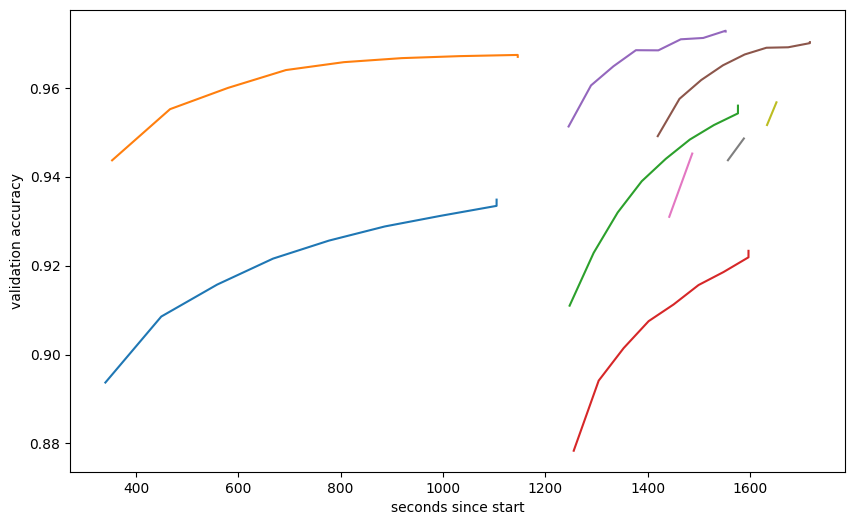

In [19]:
# wrap in try/except in case of flaky I/O issues
try:
    trials_df, curve_df = early_stopping_exp_to_df(experiment)
    plot_curves_by_wall_time(trials_df, curve_df)
except Exception as e:
    print(f"Encountered exception while plotting results: {e}")